In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn

import numpy as np
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import ast
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


In [3]:
dataset = pd.read_csv('../landmark_extraction_mechanism/labeled_dataset.csv')

In [4]:
unlabel = pd.read_csv('../landmark_extraction_mechanism/dataset.csv')

In [5]:
unlabel['label'] = dataset['Label']
dataset = unlabel

In [6]:
dataset.head(15)

,video,group,frame,landmarks,label
0,video3.mp4,1,5,[ 0 0 288.62 254....,good
1,video3.mp4,1,11,[ 0 0 287.18 255....,good
2,video3.mp4,1,17,[ 0 0 284.14 255....,good
3,video3.mp4,1,23,[ 0 0 284.85 255...,good
4,video3.mp4,1,29,[ 0 0 285.81 255....,good
5,video3.mp4,1,35,[ 0 0 286.57 255....,good
6,video3.mp4,1,41,[ 0 0 287.48 255....,good
7,video3.mp4,1,47,[ 0 0 287.85 2...,good
8,video3.mp4,1,53,[ 0 0 288.13 254....,good
9,video3.mp4,1,59,[ 0 0 289.34 254....,good


In [7]:
def is_float(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [8]:
dataset['landmarks'] = dataset['landmarks'].apply(lambda arr: np.array([float(n) for n in arr.split() if is_float(n)]))

### Dataset csv

Each row contains a video (so we can label the data), also the timestamp of the frame where that sequence set of landmarks was captured and 

In [9]:

# Group the data by 'video' and 'group'
grouped_data = dataset.groupby(['video', 'group'])

# Define the sequence length
sequence_length = 10

# Create lists to store the sequences and labels
sequences = []
labels = []

# Iterate over each group
for group, data in grouped_data:
    landmarks = data['landmarks'].tolist()
    group_labels = data['label'].tolist()
    
    # Create sequences of landmarks
    for i in range(len(landmarks) - sequence_length + 1):
        sequence = landmarks[i:i+sequence_length]
        sequences.append(sequence)
        labels.append(group_labels[i+sequence_length-1])

In [10]:
sequences = np.array(sequences)

In [11]:
scaler = MinMaxScaler()
normalized_sequences = np.zeros_like(sequences)

for i in range(sequences.shape[0]):
    for j in range(sequences.shape[1]):
        # Flatten the landmarks for each set within the sequence
        landmarks_flattened = np.reshape(sequences[i, j], (-1, 1))
        # Normalize the landmarks
        landmarks_normalized = scaler.fit_transform(landmarks_flattened)
        # Reshape the normalized landmarks back to the original shape
        normalized_landmarks = np.reshape(landmarks_normalized, sequences[i, j].shape)
        # Update the normalized landmarks in the sequences array
        normalized_sequences[i, j] = normalized_landmarks

In [12]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [13]:
label_encoder.transform(['bad'])

array([0])

In [14]:
train_X, test_X, train_y, test_y = train_test_split(normalized_sequences, labels_encoded, test_size=0.2, shuffle=True)

In [15]:
print(train_X.shape)
print(train_y)

(35, 10, 57)
[0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0]


In [16]:
train_X_tensor = torch.Tensor(train_X)
train_y_tensor = torch.Tensor(train_y)

In [17]:
train_dataset = TensorDataset(train_X_tensor, train_y_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        x = self.dropout(h_n[-1])
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.relu(x)
        return x

In [19]:
train_y

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [20]:
input_size = train_X.shape[2]
hidden_size = 256
num_classes = 1
num_epochs = 20
learning_rate = 0.01

# Instantiate the model
model = LSTMModel(input_size, hidden_size, num_classes)

In [21]:
# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
train_X.shape

(35, 10, 57)

In [23]:
model

LSTMModel(
  (lstm): LSTM(57, 256, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
)

In [84]:

epoch_accuracy = []
epoch_f1_score = []
epoch_recall = []
epoch_loss = []

for epoch in range(num_epochs):
    true_labels = []
    predicted_labels = []
    for inputs, labels in train_dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        predictions = torch.round(torch.sigmoid(outputs.squeeze()))

        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.detach().numpy())

        loss = criterion(outputs.squeeze(), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    # Store metrics for each epoch
    epoch_accuracy.append(accuracy)
    epoch_f1_score.append(f1)
    epoch_recall.append(recall)
    epoch_loss.append(loss.item())
    # Print the metrics for every epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy}, F1 Score: {f1}, Recall: {recall}')


Epoch 1/20, Loss: 0.6317258477210999, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 2/20, Loss: 0.6629362106323242, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 3/20, Loss: 0.6493331789970398, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 4/20, Loss: 0.42514947056770325, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 5/20, Loss: 0.6201693415641785, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 6/20, Loss: 0.6334384083747864, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 7/20, Loss: 0.45879730582237244, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 8/20, Loss: 0.5626592040061951, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0
Epoch 9/20, Loss: 0.6186790466308594, Accuracy: 0.34285714285714286, F1 Score: 0.5106382978723404, Recall: 1.0

In [24]:
test_X_tensor = torch.Tensor(test_X)
test_y_tensor = torch.Tensor(test_y)

test_dataset = TensorDataset(test_X_tensor, test_y_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Set shuffle to False for evaluation


In [ ]:
torch.save(model, 'best_model_ever.pt')

In [25]:
model = torch.load('best_model_ever.pt')

In [87]:

# Set the model to evaluation mode
model.eval()

# Create lists to store the predicted labels and ground truth labels
predicted_labels = []
true_labels = []

# Iterate over the test data
for inputs, labels in test_dataloader:
    # Forward pass
    outputs = model(inputs)

    # Get the predicted labels by taking the maximum probability
    _, predicted = torch.max(outputs, dim=1)

    # Append the predicted labels and true labels to the lists
    predicted_labels.extend(predicted.tolist())
    true_labels.extend(labels.tolist())

# Convert the predicted labels and true labels to numpy arrays
predicted_labels = np.array(predicted_labels)
true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.67
Precision: 0.44
Recall: 0.67
F1 Score: 0.53


/usr/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
import cv2
import matplotlib.pyplot as plt
import random

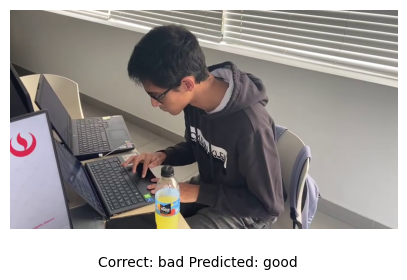

In [34]:
%matplotlib inline
def test_model(index):
	test = dataset.iloc[index]
	cap = cv2.VideoCapture('../dataset_videos/' + test['video'])
	cap.set(cv2.CAP_PROP_POS_FRAMES, test['frame'])
	ret, frame = cap.read()
	if ret:
		frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
		pose = torch.Tensor([test['landmarks']]).to('cpu')
		fig = plt.figure(figsize=(5,5))
		pred = 'bad' if round(float(model(pose)[0])) == 0 else 'good'
		plt.imshow(frame_rgb)
		plt.axis('off')
		text = f"Correct: {test['label']} Predicted: {pred}"
		fig.text(.5, .2, text, ha='center')
		plt.show()
	cap.release()
	
test_model(60)

In [107]:
pose = torch.Tensor([test['landmarks']]).to('cpu')

In [106]:
pose.shape

torch.Size([57])

In [108]:
model(pose)

tensor([0.6386], grad_fn=<ReluBackward0>)